# Reshaping data for model
### In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script

In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from logistic import logistic

# Approach 1: We import the stock data from publication

In [2]:
stock = pd.read_excel('IUS_LDV_IEA_Xu.xlsx', sheet_name='LDV_stock') # This data was part of the recent publication of Xu et al. https://www.nature.com/articles/s43246-020-00095-x
stock['geo'] = 'Global'

In [3]:
stock.head()

,year,value,unit,comment,geo
0,2019,503.000000,million,Assumed linear increase from 2019 to 2050,Global
1,2020,612.580645,million,Assumed linear increase from 2019 to 2050,Global
2,2021,722.161290,million,Assumed linear increase from 2019 to 2050,Global
3,2022,831.741935,million,Assumed linear increase from 2019 to 2050,Global
4,2023,941.322581,million,Assumed linear increase from 2019 to 2050,Global


In [4]:
stock_corr = pd.read_excel('IUS_LDV_IEA_Xu.xlsx', sheet_name='LDV_stock_corrected') # The initial value of the stock seemed completely irrealistic so it was corrected to match historic data
stock_corr['geo'] = 'Global'

In [5]:
stock_corr.head()

,year,value,unit,comment,geo
0,2019,1100.000000,million,Assumed linear increase from 2019 to 2050,Global
1,2020,1190.322581,million,Assumed linear increase from 2019 to 2050,Global
2,2021,1280.645161,million,Assumed linear increase from 2019 to 2050,Global
3,2022,1370.967742,million,Assumed linear increase from 2019 to 2050,Global
4,2023,1461.290323,million,Assumed linear increase from 2019 to 2050,Global


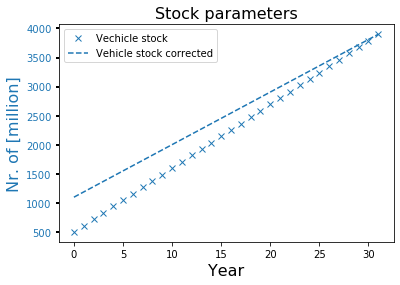

In [6]:
fig, ax1 = plt.subplots()
ax1.plot(stock.index.values, 
            stock['value'].values, 'x', color='tab:blue') 
ax1.plot(stock_corr.index.values, 
            stock_corr['value'].values, '--') 
ax1.set_ylabel('Nr. of [million]',color='tab:blue',fontsize =16)
ax1.legend(['Vechicle stock', 'Vehicle stock corrected'], loc='best',prop={'size':10})
ax1.set_title('Stock parameters', fontsize=16)
ax1.set_xlabel('Year',fontsize =16)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize='medium', width=2)

### We import the population data

In [7]:
population = pd.read_excel('world_population_UN.xlsx', sheet_name='columns')

In [8]:
population = population.rename(columns={'Location': 'year'})

In [9]:
population.rename(columns={'World':'value'}, inplace=True)

### Calculate vehicle ownership per capita

In [10]:
population.head()

,year,value
0,1950,2536275
1,1951,2583817
2,1952,2630584
3,1953,2677230
4,1954,2724302


In [11]:
stock.set_index('year', inplace=True)
stock_corr.set_index('year', inplace=True)
population.set_index('year', inplace=True)

In [12]:
vpc = stock['value']/(population['value']/1000)
vpc_corr = stock_corr['value']/(population['value']/1000)

In [13]:
vpc = pd.DataFrame(vpc)
vpc.dropna(inplace=True)

In [14]:
vpc_corr = pd.DataFrame(vpc_corr)
vpc_corr.dropna(inplace=True)

In [15]:
vpc.head()

,value
year,
2019,0.065201
2020,0.078581
2021,0.091698
2022,0.104563
2023,0.117189


### Visualize values

Text(0, 0.5, 'Vehicles per capita')

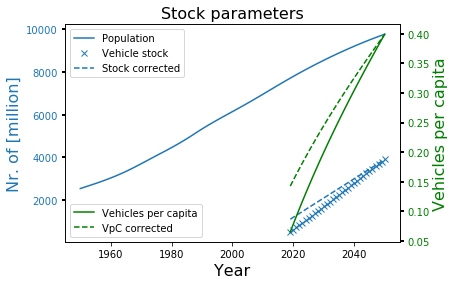

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(population.index.values, 
            population['value'].values/1000, color='tab:blue') 
ax1.plot(stock.index.values, 
            stock['value'].values, 'x', color='tab:blue') 
ax1.plot(stock_corr.index.values, 
            stock_corr['value'].values, '--') 
ax1.set_ylabel('Nr. of [million]',color='tab:blue',fontsize =16)
ax1.legend(['Population', 'Vehicle stock', 'Stock corrected'], loc='best',prop={'size':10})
ax1.set_title('Stock parameters', fontsize=16)
ax1.set_xlabel('Year',fontsize =16)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize='medium', width=2)
ax2.plot(vpc.index.values, 
            vpc['value'].values, 'g') 
ax2.plot(vpc_corr.index.values, 
            vpc_corr['value'].values, 'g--')
ax2.tick_params(axis='y', labelcolor='g', labelsize='medium', width=2)
ax2.legend(['Vehicles per capita', 'VpC corrected'], loc='lower left',prop={'size':10})
ax2.set_ylabel('Vehicles per capita', color='g', fontsize =16)

### No we fit and create some scenarios for the VpC and population

Fit vehicles per capita

In [17]:
# Trying polynomial fit
degree = 4
t = np.arange(1950,2051)
popt, pcov = curve_fit(logistic, vpc.index.values, vpc.value.values, bounds=([min(vpc.index.values), 0., 0.05, 0.], [max(vpc.index.values), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
vpc_fit = logistic(t, *popt)
popt1, pcov = curve_fit(logistic, vpc_corr.index.values, vpc_corr.value.values, bounds=([min(vpc_corr.index.values), 0., 0.05, 0.], [max(vpc_corr.index.values), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
vpc_fit_corr = logistic(t, *popt1)


Text(0.5, 0, 'Year')

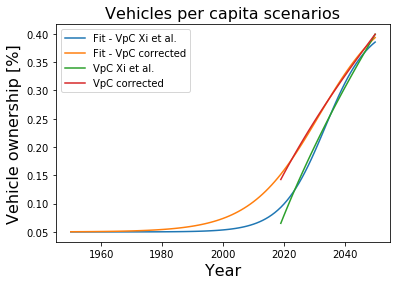

In [18]:
fig, ax = plt.subplots()
ax.plot(t, 
        vpc_fit) 
ax.plot(t, 
        vpc_fit_corr) 
ax.plot(vpc.index.values, 
        vpc['value'].values) 
ax.plot(vpc.index.values, 
        vpc_corr['value'].values) 
ax.legend(['Fit - VpC Xi et al.', 'Fit - VpC corrected', 'VpC Xi et al.', 'VpC corrected'], loc='best',prop={'size':10})
ax.set_ylabel('Vehicle ownership [%]',fontsize =16)
ax.set_title('Vehicles per capita scenarios', fontsize=16)
ax.set_xlabel('Year',fontsize =16)

### With these scenarios we can calculate the total stock of vehicles. We use the logistic fits for the population and the polynomial fit for the ownership

In [19]:
Ns = 3 # number of scenarios
Nr = 1 # number of regions
Nt = 101 # number of years

In [20]:
StockArray = np.zeros((Ns, Nr, Nt))

In [21]:
StockArray[0,:,:]= np.einsum('t,t->t', population.value.values, vpc_fit_corr) # Each scenario is multiplied corrispondingly for each variable
StockArray[1,:,:]= np.einsum('t,t->t', population.value.values, vpc_fit) # Each scenario is multiplied corrispondingly for each variable

In [22]:
# np.save('/Users/fernaag/Box/BATMAN/Data/Database/data/03_scenario_data/global_model/stock_population_vpc/IUS_World_1950_2050_Xi', StockArray, allow_pickle=True) # You can save the data generated here in an array to use in other files

# Approach 2: Use OICA data instead

In [23]:
fleet = pd.read_excel('PC_Vehicles-in-use.xlsx', skiprows=5)

In [24]:
world = fleet[fleet['REGIONS/COUNTRIES']== 'ALL COUNTRIES'].reset_index(drop=True)

In [25]:
world

,REGIONS/COUNTRIES,Unnamed: 1,Unnamed: 2,Unnamed: 3,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 15,Variation 2015/2014
0,ALL COUNTRIES,NaN,NaN,NaN,653854,679153.837395,701690.28603,727404.947327,747899.110978,775572.823905,808401.00871,834915.648607,869082.972518,907061.78083,947079.618,NaN,0.044118


In [26]:
world = world.melt()

In [27]:
world.dropna(inplace=True)

In [28]:
world.head()

,variable,value
0,REGIONS/COUNTRIES,ALL COUNTRIES
4,2005,653854
5,2006,679154
6,2007,701690
7,2008,727405


In [29]:
world.drop(index=[0, 16], inplace=True)

In [30]:
max(world.variable.values.astype(int))

2015

In [31]:
world.tail()

,variable,value
10,2011,808401
11,2012,834916
12,2013,869083
13,2014,907062
14,2015,947080


In [32]:
# Trying logistic
t = np.arange(1950,2051)
popt, pcov = curve_fit(logistic, world.variable.values, world.value.values, bounds=([min(world.variable.values.astype(int)), 0., 10000, 50000], [max(world.variable.values.astype(int)), 100, 300000, 4000000])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
world_fit = logistic(t, *popt)

In [33]:
vpc_new = world_fit/population.value.values

Text(0.5, 0, 'Year')

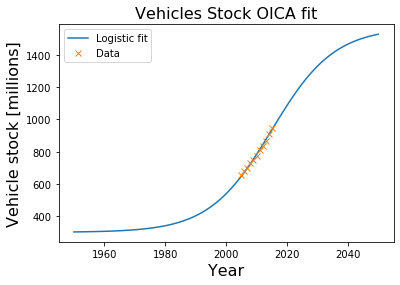

In [34]:
fig, ax = plt.subplots()
ax.plot(t, 
            world_fit/1000) 
ax.plot(world.variable.values, world.value.values/1000, 'x')
ax.legend(['Logistic fit', 'Data'], loc='best',prop={'size':10})
ax.set_ylabel('Vehicle stock [millions]',fontsize =16)
ax.set_title('Vehicles Stock OICA fit', fontsize=16)
ax.set_xlabel('Year',fontsize =16)

Text(0, 0.5, 'Vehicles per capita')

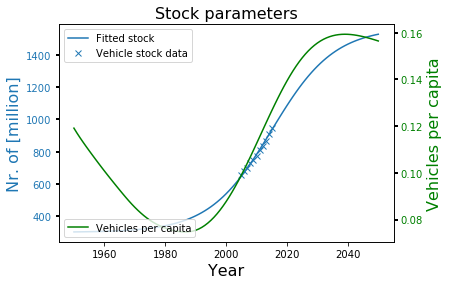

In [35]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t, 
            world_fit/1000, color='tab:blue') 
ax1.plot(world.variable.values, 
            world.value.values/1000, 'x', color='tab:blue') 
ax1.set_ylabel('Nr. of [million]',color='tab:blue',fontsize =16)
ax1.legend(['Fitted stock', 'Vehicle stock data', 'Stock corrected'], loc='best',prop={'size':10})
ax1.set_title('Stock parameters', fontsize=16)
ax1.set_xlabel('Year',fontsize =16)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize='medium', width=2)
ax2.plot(t, 
            vpc_new, 'g') 
ax2.tick_params(axis='y', labelcolor='g', labelsize='medium', width=2)
ax2.legend(['Vehicles per capita', 'VpC corrected'], loc='lower left',prop={'size':10})
ax2.set_ylabel('Vehicles per capita', color='g', fontsize =16)

Text(0.5, 0, 'Year')

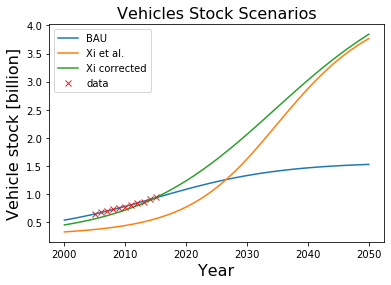

In [36]:
fig, ax = plt.subplots()
ax.plot(t[50:], 
            world_fit[50:]/1000000) 
ax.plot(t[50:], 
            np.einsum('t,t->t', population.value.values[50:], vpc_fit[50:])/1000000) 
ax.plot(t[50:], 
            np.einsum('t,t->t', population.value.values[50:], vpc_fit_corr[50:])/1000000) 
ax.plot(world.variable.values, world.value.values/1000000, 'x')
ax.legend(['BAU', 'Xi et al.', 'Xi corrected', 'data'], loc='best',prop={'size':10})
ax.set_ylabel('Vehicle stock [billion]',fontsize =16)
ax.set_title('Vehicles Stock Scenarios', fontsize=16)
ax.set_xlabel('Year',fontsize =16)

In [37]:
StockArray = np.zeros((Ns, Nr, Nt))
StockArray[0,:,:]= np.einsum('t,t->t', population.value.values, vpc_fit_corr) # High
StockArray[1,:,:]= np.einsum('t,t->t', population.value.values, vpc_fit) # Medium
StockArray[2,:,:] = world_fit # Low
# np.save('/Users/fernaag/Box/BATMAN/Data/Database/data/03_scenario_data/global_model/IUS/passengerCars_World_1950_2050_OICA', StockArray) # Here we can save the output array as well

## How could the model be improved?

## What is the main difference between the two approaches? What is more robust?